In [1]:
import keras
import cv2
import os
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
### remove a directory that cannot be deleted
# import shutil
# shutil.rmtree('/content/hand_dataset/')

In [35]:
!unzip '/content/hand_dataset.zip'

Archive:  /content/hand_dataset.zip
   creating: hand_dataset/
   creating: hand_dataset/5/
  inflating: hand_dataset/5/1.jpg    
  inflating: hand_dataset/5/10.jpg   
  inflating: hand_dataset/5/11.jpg   
  inflating: hand_dataset/5/12.jpg   
  inflating: hand_dataset/5/13.jpg   
  inflating: hand_dataset/5/14.jpg   
  inflating: hand_dataset/5/15.jpg   
  inflating: hand_dataset/5/2.jpg    
  inflating: hand_dataset/5/2022-06-21-110225.jpg  
  inflating: hand_dataset/5/2022-06-21-110226 (1).jpg  
  inflating: hand_dataset/5/2022-06-21-110226 (2).jpg  
  inflating: hand_dataset/5/2022-06-21-110226.jpg  
  inflating: hand_dataset/5/2022-06-21-110227 (1).jpg  
  inflating: hand_dataset/5/2022-06-21-110227 (2).jpg  
  inflating: hand_dataset/5/2022-06-21-110227.jpg  
  inflating: hand_dataset/5/2022-06-21-110228.jpg  
  inflating: hand_dataset/5/2022-06-21-110229 (1).jpg  
  inflating: hand_dataset/5/2022-06-21-110229 (2).jpg  
  inflating: hand_dataset/5/2022-06-21-110229 (3).jpg  
  in

In [36]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 25

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels, generator.class_indices

train_features, train_labels, dictionary = extract_features('/content/hand_dataset/', 121)

Found 121 images belonging to 2 classes.


In [37]:
train_features = np.reshape(train_features, (-1, 7 * 7 * 512))

In [38]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_features, train_labels) 

KNeighborsClassifier(n_neighbors=3)

In [39]:
dictionary

{'5': 0, 'mug': 1}

In [40]:
def get_class_name(l):
    for name, label in dictionary.items():
        if label == l:
            return name

In [41]:
get_class_name(0)

'5'

In [42]:
get_class_name(1)

'mug'

In [43]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


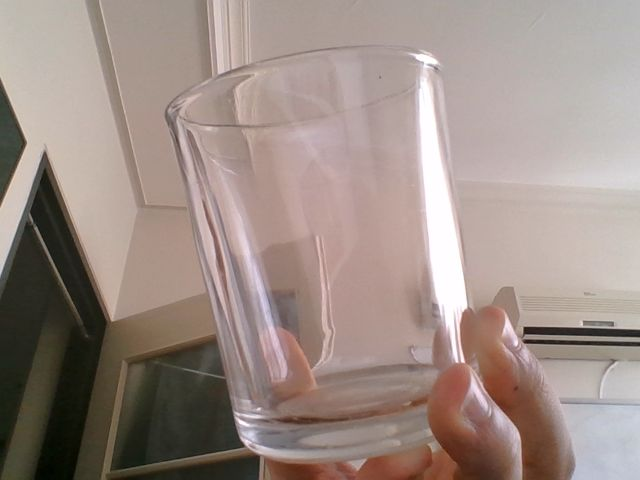

In [50]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

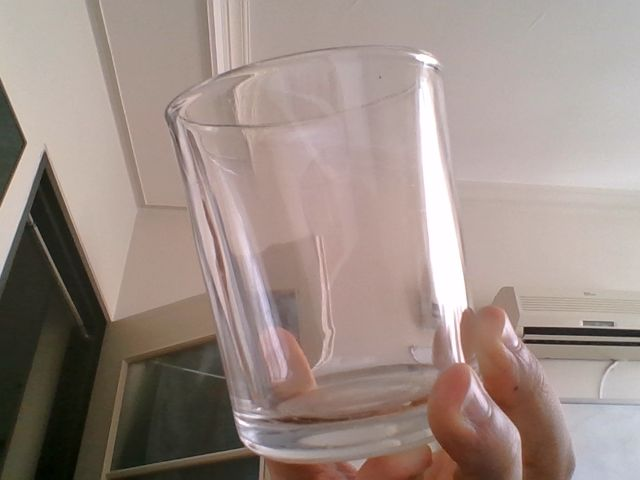

In [51]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/photo.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

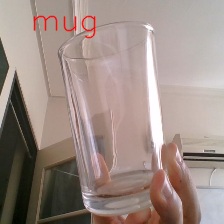

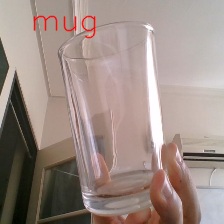

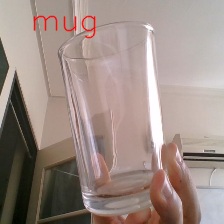

In [52]:
import cv2
cap = cv2.VideoCapture(0)
for i in range(0, 3):
    ret, frame = cap.read()
    frame = cv2.resize(img, (224, 224))
    x = np.expand_dims(frame, axis=0)
    x = preprocess_input(x)
    feature = conv_base.predict(x)
    feature = np.reshape(feature, (-1, 7 * 7 * 512))
    predicted = neigh.predict(feature)
    text = get_class_name(predicted[0])
    cv2.putText(frame,  text, (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), lineType=cv2.LINE_AA)
    cv2_imshow(frame)
cap.release()
cv2.destroyAllWindows()   